In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

In [2]:
#Import the Data set
df = pd.read_csv("data\\Traffic.csv")

print(df.head())

          Time  Date Day of the week  CarCount  BikeCount  BusCount  \
0  12:00:00 AM    10         Tuesday        31          0         4   
1  12:15:00 AM    10         Tuesday        49          0         3   
2  12:30:00 AM    10         Tuesday        46          0         3   
3  12:45:00 AM    10         Tuesday        51          0         2   
4   1:00:00 AM    10         Tuesday        57          6        15   

   TruckCount  Total Traffic Situation  
0           4     39               low  
1           3     55               low  
2           6     55               low  
3           5     58               low  
4          16     94            normal  


In [3]:
#Get the inputs and target
X = df.drop(columns="Traffic Situation")
y = df["Traffic Situation"]

#We need to convert the "Time". "Date", "Day of the week" into readable data.
#We can project it onto a circle and use this data as features in order to preserve 


#There is only 31 days in the data, so we project it onto this circle
X["day_of_the_month_sin"] = np.sin(2 * np.pi * X["Date"] / 31)
X["day_of_the_month_cos"] = np.cos(2 * np.pi * X["Date"] / 31)
X = X.drop(columns="Date")

# Well use this mappng to change the data into numerics
day_mapping = {
    'Monday': 0,
    'Tuesday': 1,
    'Wednesday': 2,
    'Thursday': 3,
    'Friday': 4,
    'Saturday': 5,
    'Sunday': 6
}

X['Day of the week'] = X['Day of the week'].map(day_mapping)

#For the Time, I want to module it all as a cylce
X["hour"] = pd.to_datetime(X["Time"], format='%I:%M:%S %p').dt.hour  
X["minute"] = pd.to_datetime(X["Time"], format='%I:%M:%S %p').dt.minute  
X["Time"] = X["hour"] * 60 + X["minute"]


X["Time_sin"] = np.sin(2 * np.pi * X["Time"] / 1425)
X["Time_cos"] = np.cos(2 * np.pi * X["Time"] / 1425)
X = X.drop(columns=['hour', 'minute', 'Time'])

#Change the target to numericas
target_mapping = {
    'heavy': 0,
    'high' : 1,
    'normal' : 2,
    'low' : 3
}

y = y.map(target_mapping)

In [4]:
print(X.dtypes)
print(y.dtypes)

Day of the week           int64
CarCount                  int64
BikeCount                 int64
BusCount                  int64
TruckCount                int64
Total                     int64
day_of_the_month_sin    float64
day_of_the_month_cos    float64
Time_sin                float64
Time_cos                float64
dtype: object
int64


In [5]:
#TODO Check these 3 different prepossers on the Data
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

# Chose a scaler
scaler = MinMaxScaler()
# scaler = StandardScaler()
# scaler = RobustScaler()

# Put all the columns in so I can normalize them
columns_to_normalize = ['Day of the week', 'CarCount', 'BikeCount', 'BusCount', 'TruckCount', 'Total', 
                        'day_of_the_month_sin', 'day_of_the_month_cos', 'Time_sin', 'Time_cos']

# Normalize the data
X[columns_to_normalize] = scaler.fit_transform(X[columns_to_normalize])

# Simple check
print(X.head())


   Day of the week  CarCount  BikeCount  BusCount  TruckCount     Total  \
0         0.166667  0.143678   0.000000      0.08       0.100  0.069767   
1         0.166667  0.247126   0.000000      0.06       0.075  0.131783   
2         0.166667  0.229885   0.000000      0.06       0.150  0.131783   
3         0.166667  0.258621   0.000000      0.04       0.125  0.143411   
4         0.166667  0.293103   0.085714      0.30       0.400  0.282946   

   day_of_the_month_sin  day_of_the_month_cos  Time_sin  Time_cos  
0              0.949479              0.277951  0.500000  1.000000  
1              0.949479              0.277951  0.533050  0.998907  
2              0.949479              0.277951  0.565955  0.995631  
3              0.949479              0.277951  0.598572  0.990187  
4              0.949479              0.277951  0.630758  0.982600  


In [6]:
#Now I need to convert the data into Tensor
X_tensor = torch.tensor(X.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.long)

In [7]:
print(X.shape)
print(X_tensor.shape)
print(y.shape)
print(y_tensor.shape)

(2976, 10)
torch.Size([2976, 10])
(2976,)
torch.Size([2976])


In [8]:

#Get the training and test data
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, train_size=0.2, random_state=42)

In [ ]:
class TrafficNN(nn.Module):
    def __init__(self):
        super(TrafficNN, self).__init__()
        #8 feautures to 4 outputs
        #TODO Try different layer combinations
        self.layer1 = nn.Linear(10,20)
        self.layer2 = nn.Linear(20,10)
        self.layer3 = nn.Linear(10,4)
        self.activation = nn.ReLU()
    def forward(self, x):
        #TODO Add in dropping Nodes
        x = self.activation(self.layer1(x))
        x = self.activation(self.layer2(x))
        x = self.layer3(x)
        return x
    
model = TrafficNN()

In [10]:
# Define loss function
criterion = nn.CrossEntropyLoss()
#TODO Try different lr and decaying learning rates/different optimizers
optimizer = optim.Adam(model.parameters(), lr=0.001) 

In [11]:
#Actually train the model
#TODO experiment with epochs
epochs = 1000
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

In [12]:
#Training Loop
epochs = 1000
for epoch in range(epochs):
    #This resets the gradient
    optimizer.zero_grad()
    outputs = model(X_train) #foward pass
    loss = criterion(outputs, y_train) #compute the loss
    loss.backward() #Do backpropagation
    optimizer.step() #update the weights

    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

Epoch [100/1000], Loss: 0.1948
Epoch [200/1000], Loss: 0.1764
Epoch [300/1000], Loss: 0.1565
Epoch [400/1000], Loss: 0.1337
Epoch [500/1000], Loss: 0.1182
Epoch [600/1000], Loss: 0.1057
Epoch [700/1000], Loss: 0.0955
Epoch [800/1000], Loss: 0.0869
Epoch [900/1000], Loss: 0.0795
Epoch [1000/1000], Loss: 0.0729


Model Accuracy: 0.9210


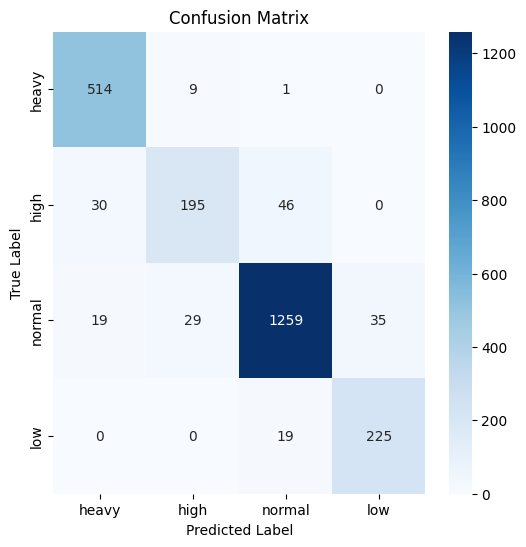

In [14]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#Make sure you can evalulate the model
model.eval()


# Disable gradient calculation for inference
with torch.no_grad():
    outputs = model(X_test)  # Forward pass
    predictions = torch.argmax(outputs, dim=1)  # Convert logits to class labels

# Compute accuracy
accuracy = accuracy_score(y_test.numpy(), predictions.numpy())
print(f"Model Accuracy: {accuracy:.4f}")

# Compute confusion matrix
cm = confusion_matrix(y_test.numpy(), predictions.numpy())

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_mapping.keys(), yticklabels=target_mapping.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()